In [1]:
import numpy as np
import pandas as pd
import hashlib
import matplotlib.pyplot as plt

# Problem 1

In [9]:
mainPath = "C:\\Users\\nizhe\\Desktop\\ESE-545\\Projects\\P1\\Netflix_data.txt"

In [10]:
# Drop all the ratings that below 3
def dropRatingsBelow3 (original_df):
#     result_df = original_df[original_df['Rating'] > 3]
    result_df = original_df[(original_df['Rating'] != 1) & (original_df['Rating'] != 2)]
    return result_df

In [11]:
# Drop the users who still have more than 20 ratings
def dropUsersAbove20 (selected_df_0):
    users_df = selected_df_0.groupby('User_id').count().reset_index().rename(columns = {'Rating' : 'count'})
    users_df = users_df[users_df['count'] > 20]
    selected_df = selected_df_0.set_index('User_id').drop(list(users_df['User_id'])).reset_index()
    return selected_df

In [12]:
def mainP1(mainPath):
    
    # Read in file
    original_df = pd.read_csv(mainPath, names = ['User_id', 'Rating', 'Date']).drop('Date', axis = 1)
    
    # Those value == 100 are movie_id rows 
    original_df.fillna(value = 100, inplace = True)
    
    # drop <3 and >20
    selected_df_0 = dropRatingsBelow3(original_df)
    selected_df = dropUsersAbove20(selected_df_0) # those rows with Rating 100 is the movie_id
    
    # get total movie and user number
    movieNum = len(selected_df[selected_df['Rating'] == 100])
    users = list(selected_df[selected_df['Rating'] != 100].groupby('User_id').count().reset_index()['User_id'].astype(int)) # a list contains all the selected users' id
    userNum = len(users)
    
    return selected_df, users, movieNum, userNum

In [13]:
def getMatrix(selected_df, users, movieNum, userNum):
    final = np.zeros((movieNum, userNum))
    movie_id = 0
    for index, row in selected_df.iterrows():
        if row['Rating'] == 100:
            movie_id += 1
            continue
        final[movie_id - 1, users.index(int(row['User_id']))] = 1
    
    return final

In [14]:
# After running the main function, we have the selected dataframe (drop the ratings below 3 and the users who rated more than 20)
# users is a list, containing all the selected users' id. We will then use the index of each id later, so this list serves as a hashmap.
selected_df, users, movieNum, userNum = mainP1(mainPath)

In [ ]:
# get the final matrix, with rows of movie_id and columns of user_id (the index in the users above)
final = getMatrix(selected_df, users, movieNum, userNum)

# Problem 2

In [7]:
def jaccardDistance(list1, list2):
    arr = np.array([list1, list2]).T
    union = len(arr[arr.sum(axis = 1) > 0])
    intersect = len(arr[arr.sum(axis = 1) == 2])
    
    return 1 - intersect / union

In [18]:
distance = []
for i in range(10000):
    a = np.random.randint(0,userNum)
    b = np.random.randint(0,userNum)

    list1 = final[:,a]
    list2 = final[:,b]

    distance.append(jaccardDistance(list1, list2))

Text(0,0.5,'Count')

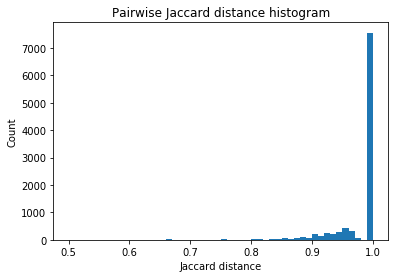

In [19]:
plt.hist(distance, bins= 50)  
plt.title("Pairwise Jaccard distance histogram")
plt.xlabel('Jaccard distance')
plt.ylabel('Count')

# Problem 3

In [240]:
hashNum = 60
nextPrime = 4507

In [241]:
# This function returns a signature matrix, and all the hash functions we used (the parameters of each are stored in hash_func, which is an np array).
def getSignatureMatrix(final, movieNum, userNum):
    
    # generate full np array as an initial signature matrix
    sig_mat = np.full((hashNum, userNum), movieNum + 1)
    
    # params for each hash function 
    hash_func = np.random.randint(0, nextPrime, (hashNum, 2))
    
    for i in range(len(users)):    
        for index in range(movieNum):
            if final[index,i] == 1:
                for j in range(0,hashNum):
                    sig_mat[j,i] = min((hash_func[j,0] * index + hash_func[j,1]) % movieNum, sig_mat[j,i])
                    
    return sig_mat, hash_func

In [242]:
sig_mat, hash_func = getSignatureMatrix(final, movieNum, userNum)

In [264]:
sig_mat

array([[ 973,   99, 1040, ...,  592,  439,   86],
       [3028,  427,  427, ...,   69,  499,   60],
       [3258,   14, 2263, ...,  782,  361,  431],
       ...,
       [3738,  137,  503, ...,  524,  188,  224],
       [4416,  188, 2104, ...,  232,    9,  406],
       [2671,   37,   37, ...,  639,  120,  207]])

In [243]:
def getHashBuckets(sig_mat, r, userNum, users):

    i = 0
    hashBuckets = []
    while i < (hashNum / r):
        
        bucket = {}

        for j in range(0, userNum):
            
            # hash each band
            band = str(sig_mat[r*i: r*i + r, j])        
            tag = hash(band)

            
            if tag not in bucket:

                bucket[tag] = dict()
                bucket[tag][j]=final[:,j]

            else:
                bucket[tag][j]=final[:,j]

        hashBuckets.append(bucket)
        i += 1
    
    return hashBuckets
    

In [244]:
hashBuckets = getHashBuckets(sig_mat, 4, userNum, users)

# Problem 4

In [373]:
pairs = set()
for i in hashBuckets:
    # i is a dict, {hash_value : {user_id : array, user_id : array}}
    

    for k in i.keys():

        if len(i[k]) == 1:
            continue

        # i[k] is a dict, {user_id : array, user_id : array}
        for user1 in i[k].keys():

            for user2 in i[k].keys():

                if (user1 > user2):

                    if jaccardDistance(i[k][user1], i[k][user2]) < 0.35:

                        pairs.add((user1, user2))                           

KeyboardInterrupt: 

In [374]:
len(pairs)

2165248

In [381]:
# export the pairs
f = open('pairs.txt','w') 
for s in pairs:
    f.write(str(s))
f.close()

# Problem 5

In [345]:
# # This function is used to generate a test data, a queried user
# def getTest(movieNum, numOfOnes):
#     test = np.zeros(movieNum)
#     loc = np.random.randint(0, movieNum, numOfOnes)
#     for i in loc:
#         test[i] = 1
#     return test

In [353]:
# get a queried user
test = final[:, 100]

In [354]:
# This function uses for generating the hash values of the queried user.
# For further comparison with the current hashBuckets
def getTagList(test, hash_func):
    tag_list = []
    sig = np.full((hashNum, 1), movieNum + 1)
    for i in range(len(test)):
        if test[i] == 1:
            for h in range(hashNum):
                sig[h, 0] = min((hash_func[h, 0] * i + hash_func[h, 1]) % movieNum , sig[h, 0])  
                
    j = 0
    
    while j < hashNum:
        
        tag_list.append(hash(str(sig[j : j + 4, 0])))
        j += 4
    
    return tag_list

In [360]:
def getNearestNeighbor(hashBuckets, tag_list, test):
    
    # result is a dict with all that hash values in the bucket
    result = dict()
    for i in tag_list:
        for hb in hashBuckets:
            if i in hb:
                result.update(hb[i])
            else:
                continue
    
    if len(result) == 0:
        return np.random.randint(1, 4499)
    
    # traverse all elements in the bucket and calculate the Jaccard Distance
    cur = 0
    dis_min = 1
    k_min = 0
    for k in result.keys():
        cur = jaccardDistance(result[k], test)
        if cur < dis_min:
            dis_min = cur
            k_min = k
    
    return k_min

In [355]:
tag_list = getTagList(test, hash_func)

In [361]:
nearestNeightbor = getNearestNeighbor(hashBuckets, tag_list, test)